In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import TFXLMRobertaModel, AutoTokenizer, TFAutoModel, AutoModelForSequenceClassification

2022-10-04 14:38:33.641825: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-10-04 14:38:33.641965: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#PREPARING TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU

print('Number of replicas:', strategy.num_replicas_in_sync)

2022-10-04 14:38:42.983906: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-04 14:38:42.987024: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-10-04 14:38:42.987071: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-04 14:38:42.987100: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cb64bb0dbe03): /proc/driver/nvidia/version does not exist
2022-10-04 14:38:42.990844: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8


In [3]:
MODEL_NAME = 'joeddav/xlm-roberta-large-xnli'
REPLICAS  = strategy.num_replicas_in_sync
TOKENIZER  = AutoTokenizer.from_pretrained(MODEL_NAME)

# HYPER-PARAMS
BATCH_SIZE = 32 * REPLICAS
MAX_LEN = 256
EPOCHS = 10
NUM_LABELS = 3

Downloading:   0%|          | 0.00/734 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

In [4]:
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
with strategy.scope():
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.2, patience=1, verbose=1,min_lr=3e-5)
    es = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

def create_model():
    with strategy.scope():

        bert_encoder = TFXLMRobertaModel.from_pretrained(MODEL_NAME)
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")


        embedding = bert_encoder(input_word_ids)[0]
        x = tf.keras.layers.GlobalAveragePooling1D()(embedding)
        x = tf.keras.layers.LayerNormalization()(x)

        output = tf.keras.layers.Dense(NUM_LABELS, activation="softmax")(x)

        model = tf.keras.models.Model(inputs=input_word_ids, outputs=output)

    return model

model = create_model()


Downloading:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some layers from the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing TFXLMRobertaModel: ['classifier']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at joeddav/xlm-roberta-large-xnli.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


## The used dataset is different from the original one.

### We added the xnli dataset (only the validation split for running time purposes) and Data Augmentation (synonyms, removal and swapping) has been performed.

In [5]:
train_df = pd.read_csv("../input/contradictory-xnli-augmented/train_df.csv")
train_df.drop(['Unnamed: 0'],axis = 1,inplace = True)

#train_df = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")

In [6]:
valid_df = pd.read_csv("../input/contradictory-xnli-augmented/valid_df.csv")
test_df = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")

In [7]:
valid_df.drop(['Unnamed: 0'],axis = 1,inplace = True)
train_df.head(5)

,premise,hypothesis,lang_abv,language,label,augmented
0,"Or, eligibility could be restricted to those w...",Eligibility is restricted to those over age 13...,en,English,1,False
1,4 اگست کو صدر بش نے صدر مشرف کو لکھا کہ دہشتگر...,صدر مشرف نے صدر بش کو فوراََجواب دیا.,ur,Urdu,1,False
2,"Какво ще стане в икономика с реинвестиране, ак...",Ние можем да търгуваме много в нашата икономика.,bg,Bulgarian,0,False
3,Twenty-eight grants targeted statewide web sit...,Grants aren't related to money.,en,English,1,False
4,28在某些情况下，需要更长的停电时间。,有时需要更长的停电时间。,zh,Chinese,0,False


# Exploratory Analysis

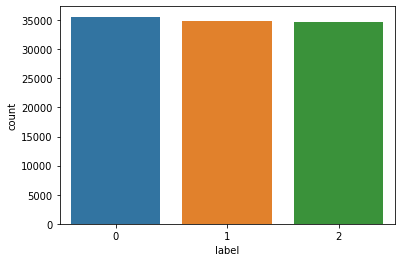

In [8]:
import seaborn as sns

sns.countplot(
   x =  train_df["label"].values,
).set_xlabel("label");

In [9]:
train_df.label.value_counts()

0    35595
1    34807
2    34673
Name: label, dtype: int64

In [10]:
train_df.isnull().sum()

premise       0
hypothesis    0
lang_abv      0
language      0
label         0
augmented     0
dtype: int64

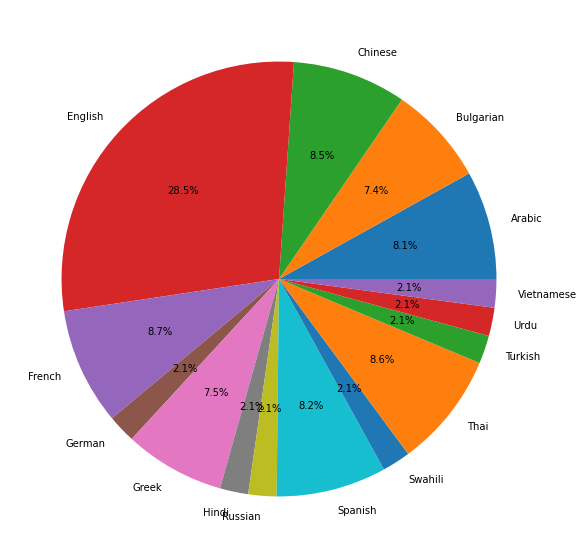

In [11]:
labels, frequencies = np.unique(train_df.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

In [12]:
print(train_df.shape[0])
print(valid_df.shape[0])

105075
9894


# SuperLoss

#### SuperLoss is a function that takes a loss function as an argument and introduces the principle of curriculum learning to a model. It is already implemented in the "fastestimator" library, however, it is using custom classes. So we have to rewrite it to make it compatible with keras.

NB : It might not be necessary to do the rewrite when using PyTorch. However, simply changing the type of the SuperLoss class bellow to a torch loss could do the trick.

In [13]:
!pip install fastestimator > /dev/null
import fastestimator

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
caip-notebooks-serverextension 1.0.0 requires google-cloud-bigquery-storage, which is not installed.
wfdb 3.4.1 requires matplotlib>=3.3.4, but you have matplotlib 3.3.3 which is incompatible.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.6.7 which is incompatible.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.3.3 which is incompatible.
pathos 0.2.8 requires dill>=0.3.4, but you have dill 0.3.3 which is incompatible.
mxnet 1.8.0.post0 requires graphviz<0.9.0,>=0.8.1, but you have graphviz 0.15 which is incompatible.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.3 which is incompatible.
matrixprofile 1.1.10 requires protobuf==3.11.2, but you have protobuf 3.18.0 which is incompatible.
imbalanced-learn 0.8.0 requires scikit-learn>=0.24, but you have scikit-l

In [14]:
import warnings
from math import e
from typing import Any, Dict, List, Optional, TypeVar, Union, Tuple, Iterable

import tensorflow.keras.losses
import numpy as np
import tensorflow as tf
import torch

from tensorflow.keras.backend import sparse_categorical_crossentropy
from fastestimator.util.traceability_util import traceable
from tensorflow.keras import backend as backend_config
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.losses as losses_utils
from tensorflow.python.keras.losses import LossFunctionWrapper

epsilon = backend_config.epsilon
Tensor = TypeVar('Tensor', tf.Tensor, torch.Tensor)


from fastestimator.backend import exp, lambertw, maximum, ones_like, pow, reduce_mean
from fastestimator.op.tensorop.loss.loss import LossOp
from fastestimator.util.util import to_number

Tensor = TypeVar('Tensor', tf.Tensor, tf.Variable, torch.Tensor)

In [15]:
class SuperLoss(LossFunctionWrapper):
    """Loss class to compute a 'super loss' (automatic curriculum learning) based on a regular loss.
    This class adds automatic curriculum learning on top of any other loss metric. It is especially useful in for noisy
    datasets. See https://papers.nips.cc/paper/2020/file/2cfa8f9e50e0f510ede9d12338a5f564-Paper.pdf for details.
    Args:
        loss: A loss object which we use to calculate the underlying regular loss. This should be an object of type
            fe.op.tensorop.loss.loss.LossOp.
        threshold: Either a constant value corresponding to an average expected loss (for example log(n_classes) for
            cross-entropy classification), or 'exp' to use an exponential moving average loss.
        regularization: The regularization parameter to use for the super loss (must by >0, as regularization approaches
            infinity the SuperLoss converges to the regular loss value).
        average_loss: Whether the final loss should be averaged or not.
        output_confidence: If not None then the confidence scores for each sample will be written into the specified
            key. This can be useful for finding difficult or mislabeled data.
    Raises:
        ValueError: If the provided `loss` has multiple outputs or the `regularization` / `threshold` parameters are
            invalid.
    """
    def __init__(self,
                 reduction=tf.keras.losses.Reduction.AUTO,
                 name="Super",
                 threshold = 'exp',
                 regularization: float = 1.0,
                 average_loss: bool = True,
                 from_logits=False,
                 label_smoothing=0.0,
                 axis=-1):

        super().__init__(
            Super,
            name=name,
            mode=threshold,
            reduction=reduction,
            from_logits=from_logits,
            axis=axis,
            average_loss=average_loss
        )
        if not isinstance(threshold, str):
            threshold = to_number(threshold).item()
        if not isinstance(threshold, float) and threshold != 'exp':
            raise ValueError(f'SuperLoss threshold parameter must be "exp" or a float, but got {threshold}')
        self.tau_method = threshold
        if regularization <= 0:
            raise ValueError(f"SuperLoss regularization parameter must be greater than 0, but got {regularization}")
        self.lam = regularization
        self.cap = -1.9999998 / e  # Slightly more than -2 / e for numerical stability
        self.initialized = {}
        self.tau = {}


def Super(target, output, mode, from_logits, axis=-1, average_loss=True):
    cap = -1.9999998 / e
    lam = 1
    tau1 = to_number('exp').item()
    target = tf.convert_to_tensor(target)
    output = tf.convert_to_tensor(output)
    target.shape.assert_is_compatible_with(output.shape)

    output, from_logits = _get_logits(
        output, from_logits, "Softmax", "sparse_categorical_crossentropy"
    )
    if from_logits:
        return tf.nn.softmax_cross_entropy_with_logits(
            labels=target, logits=output, axis=axis
        )
    base_loss = sparse_categorical_crossentropy(target, output, from_logits, axis)
    tau = tf.convert_to_tensor(tau1[mode], tau1[mode] - 0.1 * (tau1[mode] - reduce_mean(base_loss)))
    beta = (base_loss - tau) / lam
    # TODO The authors say to remove the gradients. Need to check whether this is necessary (speed or metrics)
    ln_sigma = -lambertw(0.5 * maximum(cap, beta))
    super_loss = (base_loss - tau) * exp(ln_sigma) + lam * pow(ln_sigma, 2)

    if average_loss:
        super_loss = reduce_mean(super_loss)

    return super_loss


def _assign(variable: Tensor, value: Tensor) -> None:
    """In place assignment of `value` to a `variable`.
    Args:
        variable: The tensor to be modified.
        value: The new value to be inserted into the `variable`.
    """
    if isinstance(variable, torch.Tensor):
        variable.copy_(value.detach())
    else:
        variable.assign(value)

def _get_logits(output, from_logits, op_type, fn_name):
    output_ = output
    from_logits_ = from_logits

    has_keras_logits = hasattr(output, "_keras_logits")
    if has_keras_logits:
        output_ = output._keras_logits
        from_logits_ = True

    from_expected_op_type = (
        not isinstance(output, (tf.Tensor, tf.Variable))
        and output.op.type == op_type
    ) and not has_keras_logits

    if from_expected_op_type:
        # When softmax activation function is used for output operation, we
        # use logits from the softmax function directly to compute loss in order
        # to prevent collapsing zero when training.
        # See b/117284466
        assert len(output.op.inputs) == 1
        output_ = output.op.inputs[0]
        from_logits_ = True

    if from_logits and (has_keras_logits or from_expected_op_type):
        warnings.warn(
            f'"`{fn_name}` received `from_logits=True`, but '
            f"the `output` argument was produced by a {op_type} "
            "activation and thus does not represent logits. "
            "Was this intended?",
            stacklevel=2,
        )

    return output_, from_logits_

# Run the Train

In [16]:
def encode(input_text):
    inputs = TOKENIZER.batch_encode_plus(input_text, 
                                         padding = 'max_length', 
                                         max_length = MAX_LEN, 
                                         truncation = True)
    return inputs

In [17]:
AUTO = tf.data.experimental.AUTOTUNE


def create_dataset(X, y, split):
    train_input = encode(X.values.tolist())['input_ids']
    if split=='train':
        train_dataset = (
            tf.data.Dataset
            .from_tensor_slices((train_input,tf.keras.utils.to_categorical(y)))
            .repeat()
            .batch(BATCH_SIZE)
            .prefetch(AUTO)
        )
    elif split=='valid':
        train_dataset = (
            tf.data.Dataset
            .from_tensor_slices((train_input,tf.keras.utils.to_categorical(y)))
            .batch(BATCH_SIZE)
        )

    return train_dataset

In [18]:
MAX_LEN

256

In [19]:
## Predicting test set output
test_X = test_df['premise'] + ' [SEP] ' + test_df['hypothesis']
testing_input = encode(test_X.values.tolist())['input_ids']
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(testing_input)
    .batch(BATCH_SIZE)
)

In [20]:
with strategy.scope():
    model.compile(optimizer = tf.keras.optimizers.Adam(1e-5), loss = SuperLoss(), metrics = ['accuracy'])
    model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 256)]             0         
_________________________________________________________________
tfxlm_roberta_model (TFXLMRo TFBaseModelOutputWithPool 559890432 
_________________________________________________________________
global_average_pooling1d (Gl (None, 1024)              0         
_________________________________________________________________
layer_normalization (LayerNo (None, 1024)              2048      
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 559,895,555
Trainable params: 559,895,555
Non-trainable params: 0
_________________________________________________________________


In [21]:
with strategy.scope():
    train_df['input_text']=train_df['premise'] + ' [SEP] ' + train_df['hypothesis']
    train_ds = create_dataset(train_df['input_text'],train_df['label'],'train')

In [22]:
with strategy.scope():
    valid_df['input_text'] = valid_df['premise'] + ' [SEP] ' + valid_df['hypothesis']
    valid_ds = create_dataset(valid_df['input_text'],valid_df['label'],'valid')

In [23]:
EVAL_INTERVAL = train_df.shape[0]//BATCH_SIZE

history = model.fit(train_ds,
             validation_data = valid_ds,
             steps_per_epoch = EVAL_INTERVAL,
             batch_size = BATCH_SIZE,
             epochs = EPOCHS,
             verbose = 1,
             shuffle= True,
             callbacks=[es,reduce_lr])

Epoch 1/10


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


410/410 [==============================] - 486s 825ms/step - loss: 0.4475 - accuracy: 0.7939 - val_loss: 0.0888 - val_accuracy: 0.9734
Epoch 2/10
410/410 [==============================] - 308s 752ms/step - loss: 0.1190 - accuracy: 0.9583 - val_loss: 0.0936 - val_accuracy: 0.9734
Epoch 3/10
410/410 [==============================] - 309s 753ms/step - loss: 0.0742 - accuracy: 0.9744 - val_loss: 0.1067 - val_accuracy: 0.9716
Epoch 4/10
410/410 [==============================] - 309s 753ms/step - loss: 0.0531 - accuracy: 0.9812 - val_loss: 0.1122 - val_accuracy: 0.9730


In [24]:
preds=model.predict(test_dataset)
preds=preds.argmax(-1)

In [25]:
preds

array([2, 1, 0, ..., 0, 0, 2])

In [26]:
output_df=pd.DataFrame({"id":test_df['id'], "prediction": preds})
output_df.set_index("id", inplace=True)
output_df.to_csv("submission.csv")

In [27]:
output_df.shape

(5195, 1)

In [28]:
output_df

,prediction
id,
c6d58c3f69,2
cefcc82292,1
e98005252c,0
58518c10ba,1
c32b0d16df,1
...,...
5f90dd59b0,1
f357a04e86,2
1f0ea92118,0
